##Import Libraries##


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

from collections import defaultdict


from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ( precision_score, recall_score, f1_score, classification_report, accuracy_score)

import unicodedata
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Load Datasets##

In [3]:
train_dataset = pd.read_csv("train.csv", encoding="latin-1")
test_dataset = pd.read_csv("test.csv", encoding="latin-1")

#train_dataset = train_dataset.sample(n=1500, random_state=42).reset_index(drop=True)
#test_dataset = test_dataset.sample(n=3000, random_state=42).reset_index(drop=True)

In [4]:
train_dataset

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
test_dataset

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


##Handling Missing Values##

In [7]:
print(train_dataset.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
train_dataset = train_dataset.dropna(how="any", axis=1)
train_dataset['text_len'] = train_dataset['text'].apply(lambda x: len(x.split(' ')))

train_dataset

C:\Users\User\AppData\Local\Temp\ipykernel_14492\903178674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['text_len'] = train_dataset['text'].apply(lambda x: len(x.split(' ')))


,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,10872,Police investigating after an e-bike collided ...,1,19


##EDA##


In [10]:
groups = train_dataset.groupby('target')['target'].agg('count').values
groups

array([4342, 3271], dtype=int64)

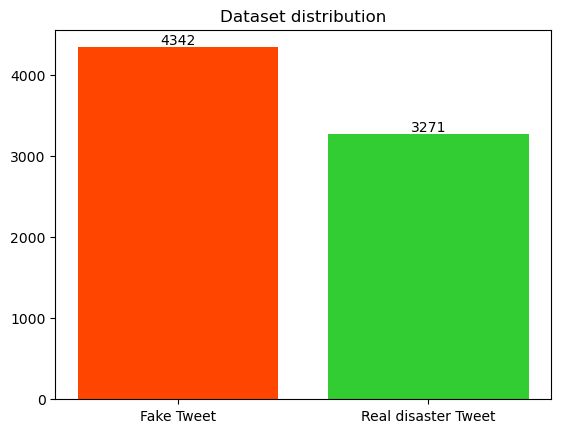

In [11]:
x = ['Fake Tweet', 'Real disaster Tweet']
y = [groups[0], groups[1]]
colors = ['#FF4500', '#32CD32']

# Create figure and bar chart with colors
fig, ax = plt.subplots()
bars = ax.bar(x, y, color=colors)
# Adding text labels on bars
for bar, value in zip(bars, y):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Position x of the text
        bar.get_height(),                   # Position and of the text (above the bar)
        f'{value}',                         # Text with the value
        ha='center', va='bottom'            # Horizontal and vertical alignment
    )
plt.title('Dataset distribution')
plt.show()

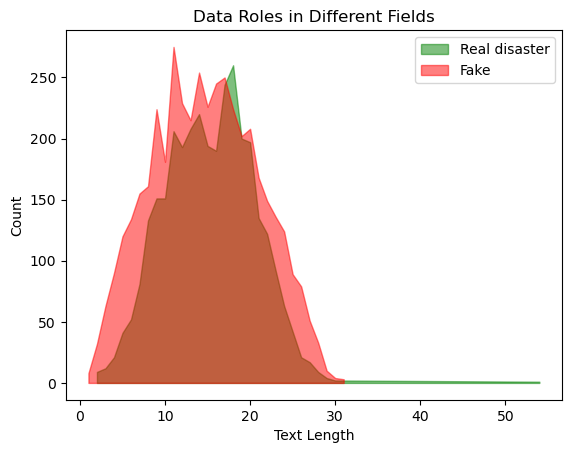

In [12]:
# Filtering and counting the length of texts for each category
disaster = train_dataset[train_dataset['target'] == 1]['text_len'].value_counts().sort_index()
fake = train_dataset[train_dataset['target'] == 0]['text_len'].value_counts().sort_index()

# Create the figure and axes
fig, ax = plt.subplots()

# Plot lines with filled areas
ax.fill_between(disaster.index, disaster.values, alpha=0.5, label='Real disaster', color='green')
ax.fill_between(fake.index, fake.values, alpha=0.5, label='Fake', color='red')

ax.set_title('Data Roles in Different Fields')
ax.set_xlabel('Text Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

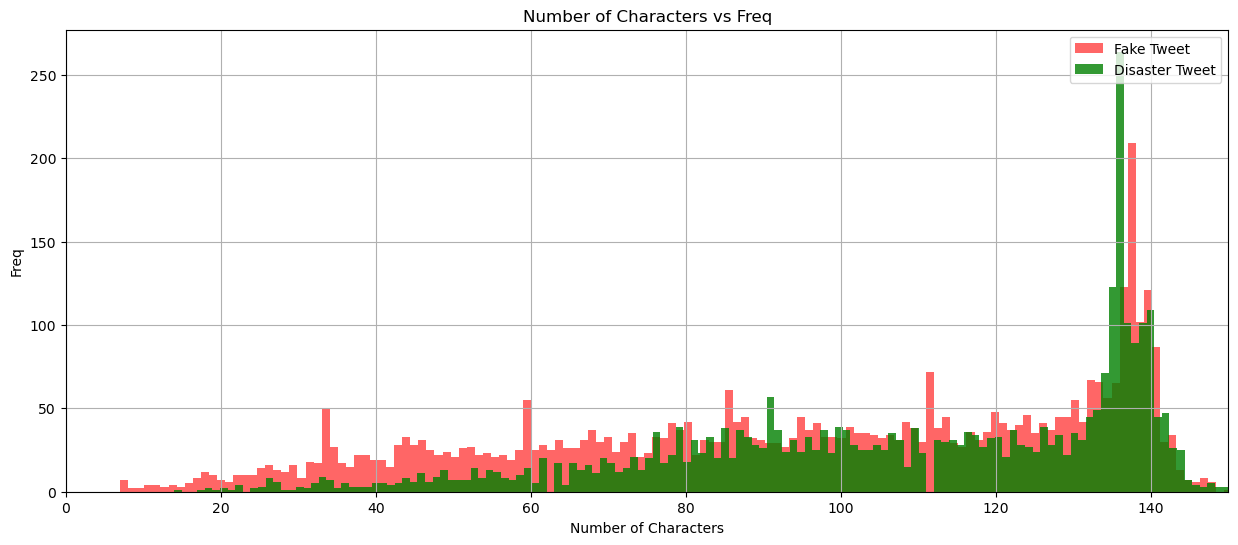

In [13]:
def length(text):
    return len(text)

train_dataset['c_length'] = train_dataset['text'].apply(length)

plt.rcParams['figure.figsize'] = (15.0, 6.0)
bins = 150
plt.hist(train_dataset[train_dataset['target'] == 0]['c_length'], alpha=0.6, bins=bins, color='red', label='Fake Tweet')
plt.hist(train_dataset[train_dataset['target'] == 1]['c_length'], alpha=0.8, bins=bins, color='green', label='Disaster Tweet')
plt.title('Number of Characters vs Freq')
plt.xlabel('Number of Characters')
plt.ylabel('Freq')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()
     

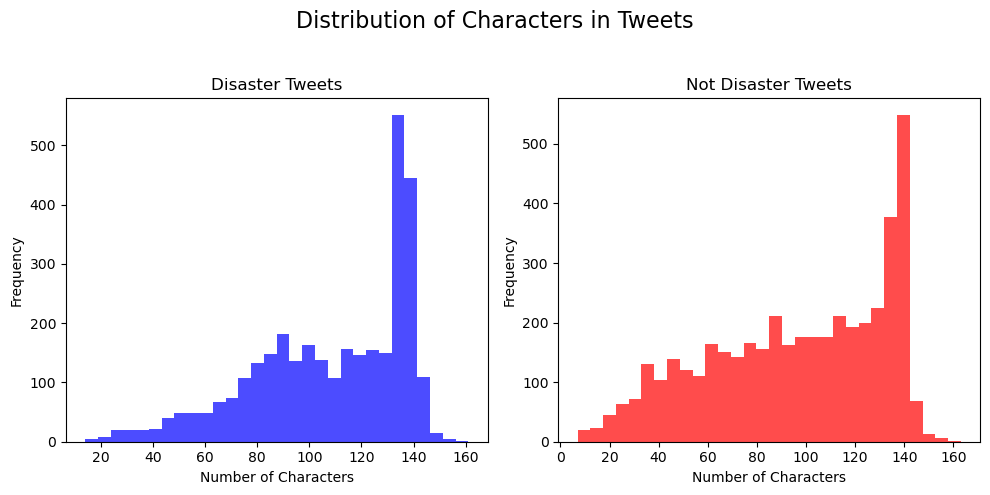

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram for disaster tweets
tweet_len = train_dataset[train_dataset['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color='blue', bins=30, alpha=0.7)
ax1.set_title('Disaster Tweets')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

# Histogram for non-disaster tweets.
tweet_len = train_dataset[train_dataset['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color='red', bins=30, alpha=0.7)
ax2.set_title('Not Disaster Tweets')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')


fig.suptitle('Distribution of Characters in Tweets', fontsize=16)

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##Preprocessing Dataset##

Remove words that do not provide information

In [17]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

In [18]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # Emoticons
        u'\U0001F300-\U0001F5FF'  # Symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # Transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # Flags (iOS)
        u'\U00002702-\U000027B0'  # Miscellaneous symbols
        u'\U000024C2-\U0001F251'  # Other symbols
        ']+',
        flags=re.UNICODE
    )
    return emoji_pattern.sub('', text)

In [19]:
def remove_html_tags(text):
    html_pattern = re.compile(r'<.*?>|&(?:[a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html_pattern.sub('', text)

In [20]:
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [21]:
def preprocess_text(input_text):
  # replace abbreviations with their long form
    cleaned_text = str(input_text)
    cleaned_text = re.sub(r"\bI'm\b", "I am", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\byou're\b", "you are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bthey're\b", "they are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bcan't\b", "cannot", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bwon't\b", "will not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bdon't\b", "do not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bdoesn't\b", "does not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bain't\b", "am not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bwe're\b", "we are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bit's\b", "it is", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bu\b", "you", cleaned_text, flags=re.IGNORECASE)

    cleaned_text = re.sub(r">", ">", cleaned_text)
    cleaned_text = re.sub(r"<", "<", cleaned_text)
    cleaned_text = re.sub(r"&", "&", cleaned_text)

    # Correction of common errors and relevant abbreviations
    cleaned_text = re.sub(r"\bw/\b", "with", cleaned_text)  # "w/" → "with"
    cleaned_text = re.sub(r"\blmao\b", "laughing my ass off", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"<3", "love", cleaned_text)  # Corazón → "love"
    cleaned_text = re.sub(r"\bph0tos\b", "photos", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bamirite\b", "am I right", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\btrfc\b", "traffic", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\b16yr\b", "16 year", cleaned_text)

    cleaned_text = str(cleaned_text).lower()  # Convert to lowercase

    # Remove unwanted patterns
    cleaned_text = re.sub(r'', '', cleaned_text)  # Remove content inside brackets
    cleaned_text = re.sub(r'\n', ' ', cleaned_text)  # Replace newlines with spaces
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)  # Remove words with numbers

    cleaned_text = remove_urls(cleaned_text)  # Remove URLs
    cleaned_text = remove_emojis(cleaned_text)  # Remove emojis
    cleaned_text = remove_html_tags(cleaned_text)  # Remove HTML tags
    cleaned_text = remove_punctuation(cleaned_text)  # Remove punctuation

    return cleaned_text

In [22]:
# Download resources needed for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()  # <-- We use lemmatizer

# Add additional context-specific words
extra_stop_words = ['u', 'im', 'r']  # Common abbreviations
extra_stop_words2 = [
    'u', 'im', 'r', 'ur', 'pls', 'thx',  # Common abbreviations
    'b4', 'omw', 'ppl', 'msg', 'lvl',    # Fast communication
    'sos', '911', 'help', 'asap',        # Emergencies
    'wtf', 'omg', 'idk', 'nvm',          # Emotional reactions
    'brb', 'btw', 'lmk', 'imo',          # Rapid coordination
    'stay', 'safe', 'evacuate', 'fyi'    # Indications and recommendations
]

all_stop_words = stop_words_list + extra_stop_words + extra_stop_words2 # Combine both stop word lists

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def process_tweet_content(tweet):
    cleaned_tweet = preprocess_text(tweet) # Clean up text by removing URLs, punctuation, HTML, etc.
    processed_tweet = ' '.join(lemmatizer.lemmatize(word) for word in cleaned_tweet.split() if word not in stop_words_list) # Eliminating stopwords and applying lemmatization instead of stemming

    return processed_tweet
     

In [24]:
train_dataset['text_clean'] = train_dataset['text'].apply(process_tweet_content)
train_dataset

,id,text,target,text_len,c_length,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,133,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,65,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,88,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11,83,two giant crane holding bridge collapse nearby...
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20,125,ariaahrary thetawniest control wild fire calif...
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,65,utc volcano hawaii
7611,10872,Police investigating after an e-bike collided ...,1,19,137,police investigating ebike collided car little...


In [25]:
test_dataset['text_clean'] = test_dataset['text'].apply(process_tweet_content)
test_dataset

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...,earthquake safety los angeles âãã safety fa...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city hardest hit...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo


##Corpus##

In [27]:
def build_corpus_from_df(dataframe, target_value):
    #Build a corpus of words from the given dataframe based on the target value.
    corpus = []

    # Filter tweets by target value and split into words.
    for words in dataframe[dataframe['target'] == target_value]['text_clean'].str.split():
        for word in words:
            corpus.append(word)

    return corpus

In [28]:
disaster_corpus = build_corpus_from_df(train_dataset, 1)
word_frequency = defaultdict(int) # Initializing a dictionary to count word frequency
# Counting the frequency of each word in the corpus of disaster tweets.
for word in disaster_corpus:
    word_frequency[word] += 1

top_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the words by frequency in descending order and take the 10 most frequent ones
top_words # Display the 10 most frequent words

[('fire', 262),
 ('news', 136),
 ('via', 121),
 ('disaster', 118),
 ('california', 115),
 ('year', 113),
 ('suicide', 110),
 ('police', 107),
 ('people', 106),
 ('family', 105)]

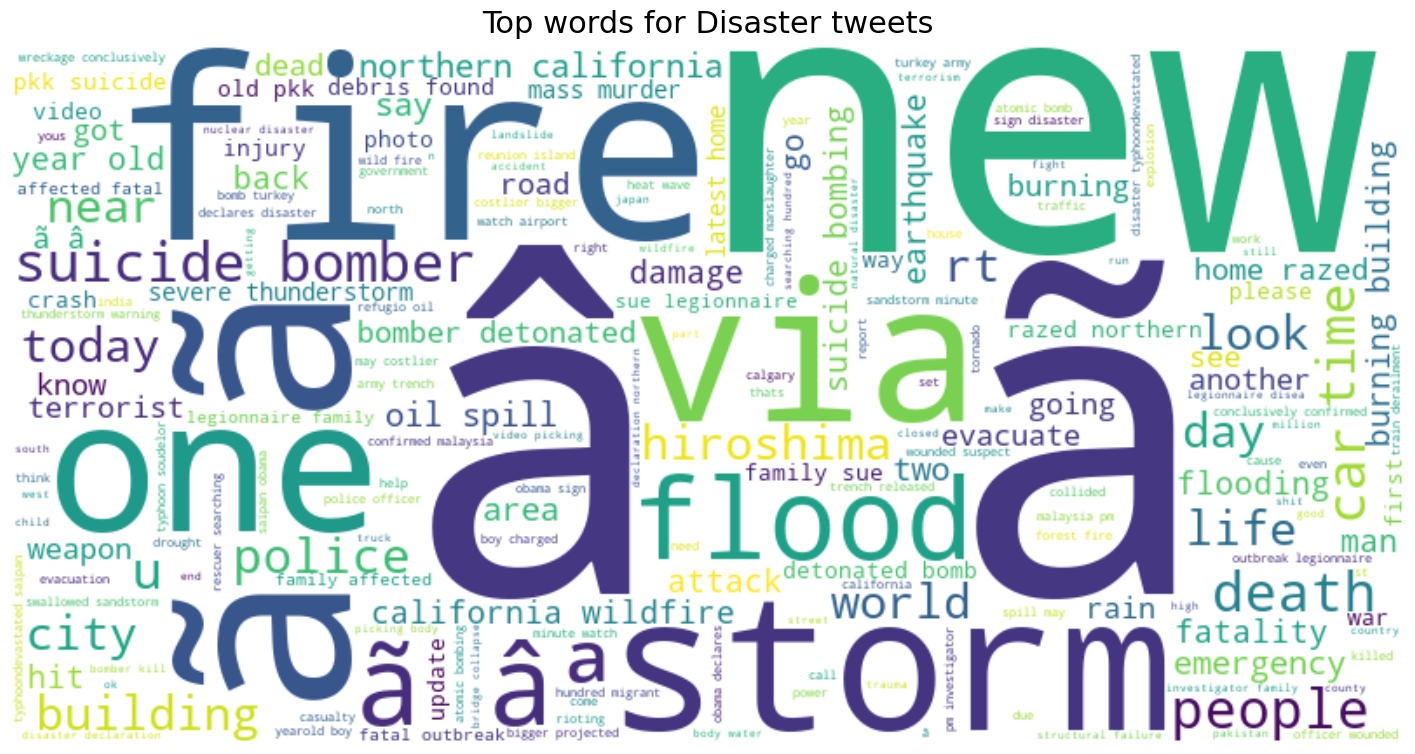

In [29]:
word_cloud = WordCloud( background_color='white', max_words=200, width=800, height=400)  # Adjust image size, max words


text = ' '.join(train_dataset.loc[train_dataset['target'] == 1, 'text_clean']) # Generate word cloud with real disaster tweets.
word_cloud.generate(text)

# Configuring and displaying the word cloud
plt.figure(figsize=(18, 10))
plt.title('Top words for Disaster tweets',fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
print(word_cloud.words_.keys())

dict_keys(['â ã', 'new', 'fire', 'ã ã', 'via', 'storm', 'one', 'flood', 'ã âª', 'suicide bomber', 'car', 'people', 'death', 'time', 'u', 'police', 'look', 'building', 'day', 'world', 'rt', 'life', 'hiroshima', 'near', 'city', 'today', 'northern california', 'emergency', 'two', 'area', 'say', 'oil spill', 'man', 'back', 'attack', 'california wildfire', 'burning building', 'damage', 'fatality', 'suicide bombing', 'flooding', 'go', 'year old', 'earthquake', 'hit', 'bomber detonated', 'got', 'dead', 'know', 'burning', 'terrorist', 'home razed', 'rain', 'see', 'road', 'another', 'weapon', 'going', 'evacuate', 'ã â', 'severe thunderstorm', 'mass murder', 'latest home', 'razed northern', 'pkk suicide', 'detonated bomb', 'update', 'first', 'injury', 'video', 'old pkk', 'photo', 'crash', 'please', 'way', 'war', 'debris found', 'family sue', 'sue legionnaire', 'legionnaire family', 'family affected', 'affected fatal', 'fatal outbreak', 'outbreak legionnaire', 'year', 'casualty', 'collided', 'ato

In [31]:
corpus_disaster_tweets_fake = build_corpus_from_df(train_dataset, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets_fake:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 255),
 ('get', 185),
 ('new', 168),
 ('one', 136),
 ('body', 116),
 ('time', 103),
 ('video', 102),
 ('via', 99),
 ('would', 97),
 ('day', 96)]

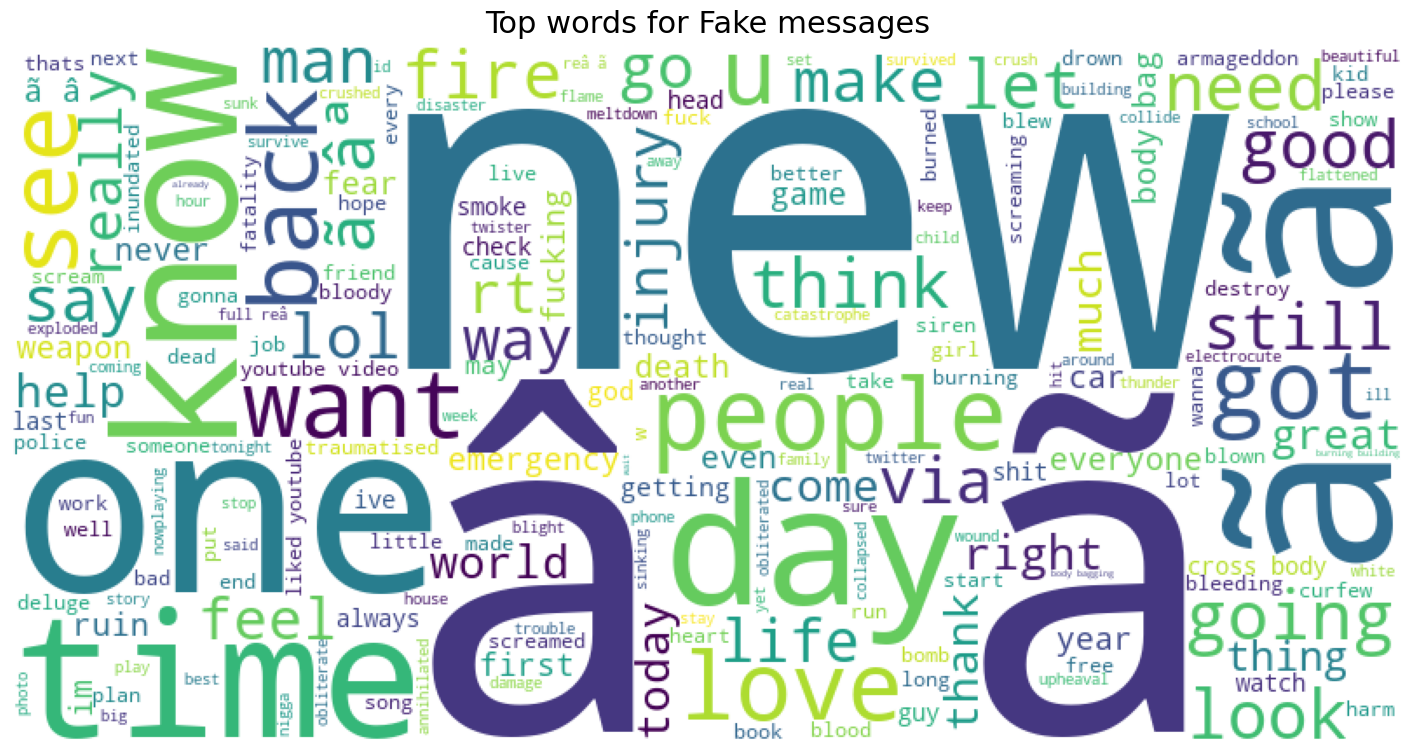

In [32]:
word_cloud2 = WordCloud(background_color='white',max_words=200,width=800,height=400)
word_cloud2.generate(' '.join(text for text in train_dataset.loc[train_dataset['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages',fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(word_cloud2)
plt.axis("off")
plt.show()
     

In [33]:
print(word_cloud2.words_.keys())

dict_keys(['new', 'â ã', 'one', 'ã ã', 'time', 'know', 'day', 'people', 'see', 'got', 'love', 'want', 'back', 'u', 'going', 'ã âª', 'look', 'need', 'let', 'think', 'good', 'fire', 'still', 'via', 'man', 'say', 'go', 'make', 'lol', 'way', 'life', 'really', 'feel', 'rt', 'injury', 'right', 'help', 'come', 'thank', 'world', 'today', 'great', 'much', 'thing', 'emergency', 'death', 'body bag', 'fear', 'never', 'year', 'even', 'everyone', 'weapon', 'ã â', 'first', 'game', 'fucking', 'car', 'im', 'ruin', 'getting', 'god', 'may', 'cross body', 'shit', 'last', 'guy', 'smoke', 'always', 'check', 'head', 'ive', 'watch', 'youtube video', 'every', 'siren', 'thats', 'bad', 'liked youtube', 'someone', 'bloody', 'hope', 'better', 'armageddon', 'burning', 'fuck', 'made', 'work', 'plan', 'free', 'screaming', 'well', 'gonna', 'girl', 'song', 'blew', 'w', 'screamed', 'traumatised', 'job', 'run', 'lot', 'little', 'put', 'harm', 'deluge', 'end', 'police', 'cause', 'live', 'destroy', 'take', 'start', 'friend

## Cleaning - Second Round ##

In [43]:
custom_words = {'im', 'u','â', 'ã', 'one', 'ã ã', 'ã ã', 'ã âª', 'ã â', 'â ã', 'â', 'âª','â', 'ã','aaa', 'rt','aa', 'ye'}# List of specific words to be deleted

def normalize_text(text):
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') # Normalize to NFKD form and remove non-ASCII characters
    return normalized_text

def remove_specific_words(tweet):
    tweet = normalize_text(tweet) # Normalize text to avoid coding problems
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)).lower() # Remove punctuation and convert to lowercase
    cleaned_tweet = ' '.join(word for word in tweet.split() if word not in custom_words) # Filter out unwanted words

    return cleaned_tweet

train_dataset['text_clean'] = train_dataset['text_clean'].apply(remove_specific_words) # Apply the function to the DataFrame in the column 'text_clean'.
     

In [45]:
disaster_corpus = build_corpus_from_df(train_dataset, 1)
word_frequency = defaultdict(int) # Initializing a dictionary to count word frequency

# Counting the frequency of each word in the corpus of disaster tweets.
for word in disaster_corpus:
    word_frequency[word] += 1

top_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the words by frequency in descending order and take the 10 most frequent ones
top_words # Display the 10 most frequent words

[('fire', 262),
 ('news', 136),
 ('via', 121),
 ('disaster', 118),
 ('california', 115),
 ('year', 113),
 ('suicide', 110),
 ('police', 107),
 ('people', 106),
 ('family', 105)]

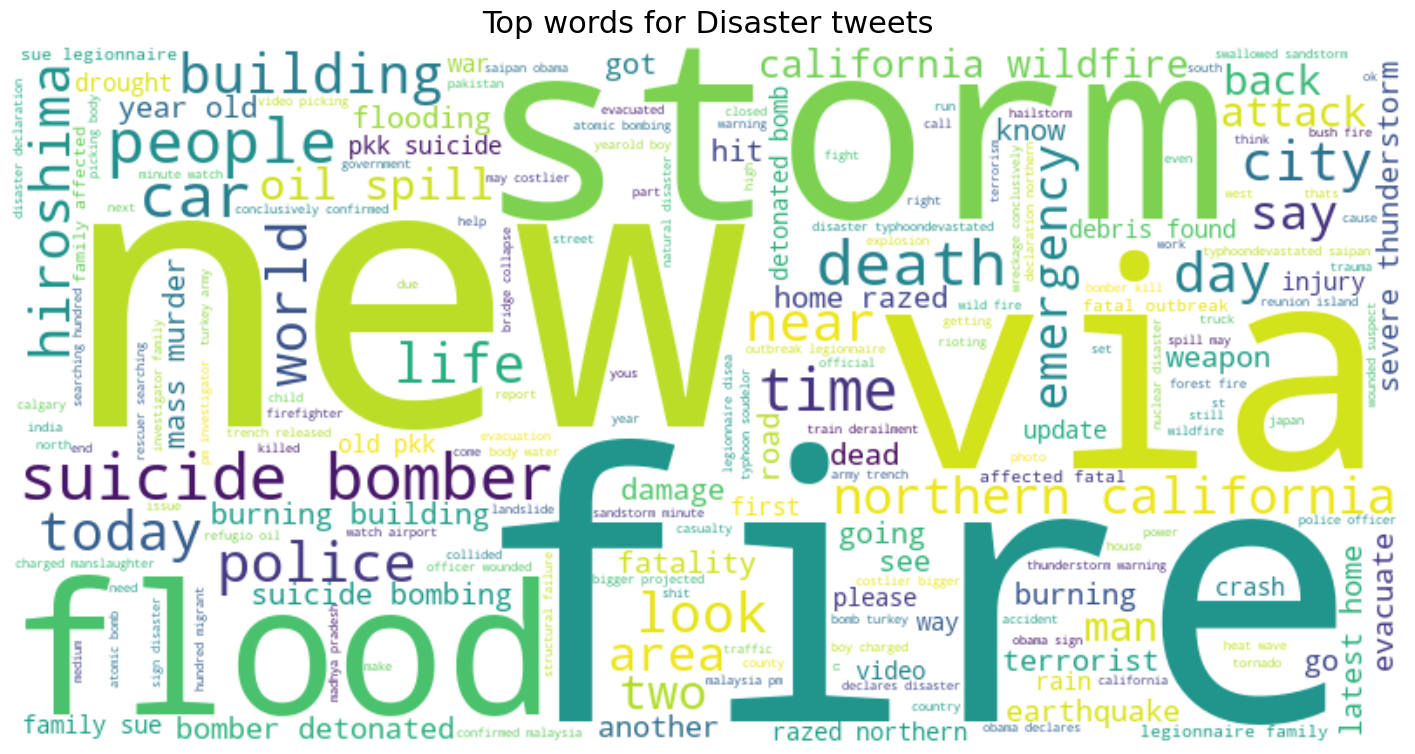

In [46]:
word_cloud = WordCloud(background_color='white', max_words=200, width=800, height=400)
text = ' '.join(train_dataset.loc[train_dataset['target'] == 1, 'text_clean']) # Generate word cloud with real disaster tweets.
word_cloud.generate(text)

# Configuring and displaying the word cloud
plt.figure(figsize=(18, 10))
plt.title('Top words for Disaster tweets',fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
print(word_cloud.words_.keys())

dict_keys(['new', 'fire', 'via', 'storm', 'flood', 'suicide bomber', 'car', 'people', 'death', 'time', 'police', 'look', 'building', 'day', 'world', 'life', 'hiroshima', 'city', 'near', 'today', 'northern california', 'emergency', 'two', 'area', 'say', 'oil spill', 'man', 'back', 'attack', 'california wildfire', 'burning building', 'damage', 'fatality', 'suicide bombing', 'flooding', 'go', 'year old', 'earthquake', 'hit', 'bomber detonated', 'got', 'dead', 'know', 'burning', 'terrorist', 'home razed', 'see', 'road', 'another', 'weapon', 'going', 'evacuate', 'severe thunderstorm', 'mass murder', 'latest home', 'razed northern', 'pkk suicide', 'detonated bomb', 'update', 'rain', 'first', 'injury', 'video', 'old pkk', 'crash', 'please', 'way', 'war', 'drought', 'debris found', 'family sue', 'sue legionnaire', 'legionnaire family', 'family affected', 'affected fatal', 'fatal outbreak', 'outbreak legionnaire', 'photo', 'year', 'casualty', 'collided', 'atomic bomb', 'train derailment', 'obam

In [50]:
corpus_disaster_tweets_fake = build_corpus_from_df(train_dataset, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets_fake:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top
     

[('like', 255),
 ('get', 185),
 ('new', 168),
 ('body', 116),
 ('time', 103),
 ('video', 102),
 ('via', 99),
 ('would', 97),
 ('day', 96),
 ('love', 94)]

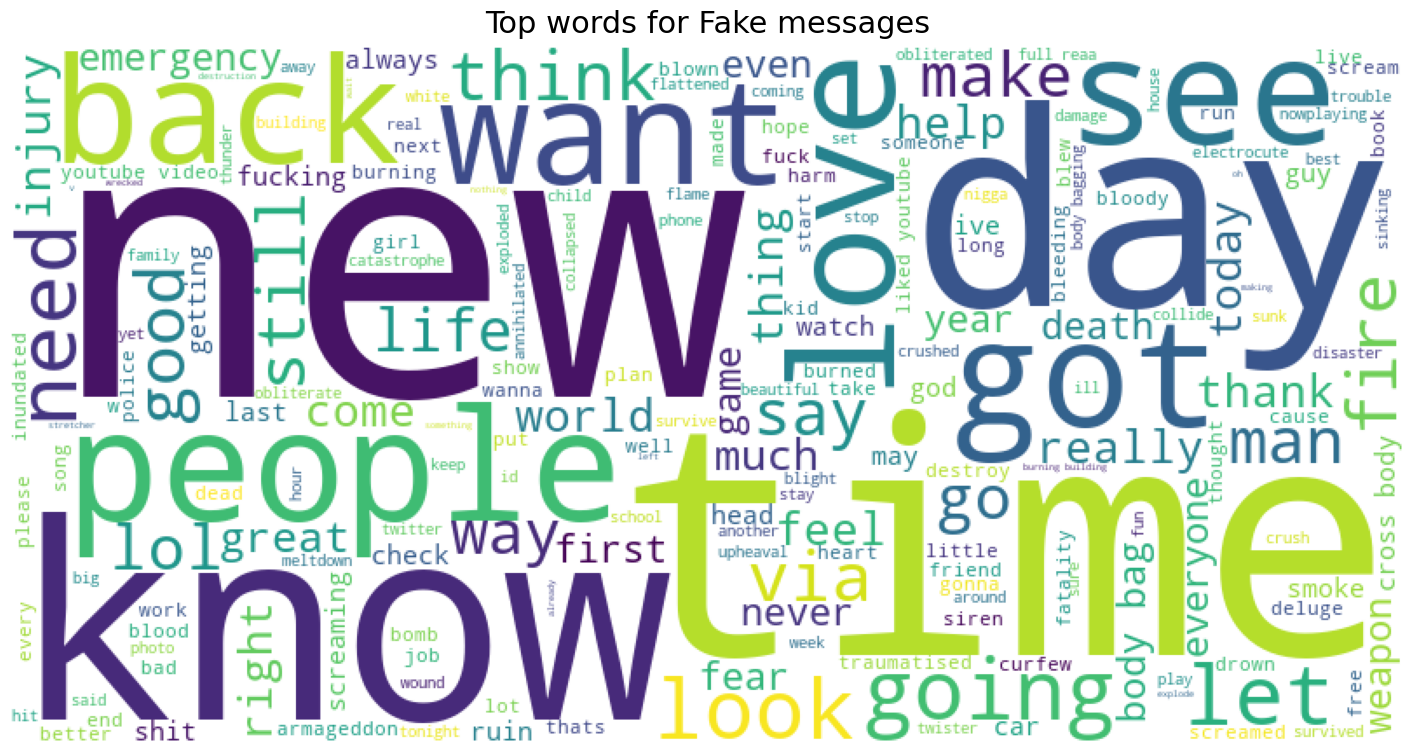

In [58]:
word_cloud2 = WordCloud(background_color='white',max_words=200,width=800,height=400)
word_cloud2.generate(' '.join(text for text in train_dataset.loc[train_dataset['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages', fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(word_cloud2)
plt.axis("off")
plt.show()

In [59]:
print(word_cloud2.words_.keys())

dict_keys(['new', 'time', 'know', 'day', 'people', 'see', 'got', 'want', 'back', 'love', 'going', 'let', 'look', 'need', 'think', 'via', 'good', 'fire', 'still', 'man', 'say', 'go', 'make', 'lol', 'way', 'life', 'really', 'feel', 'injury', 'thing', 'right', 'help', 'come', 'thank', 'world', 'today', 'great', 'much', 'emergency', 'death', 'body bag', 'fear', 'never', 'year', 'even', 'everyone', 'weapon', 'first', 'game', 'fucking', 'car', 'ruin', 'getting', 'god', 'may', 'cross body', 'shit', 'last', 'guy', 'screaming', 'smoke', 'always', 'check', 'head', 'ive', 'watch', 'youtube video', 'every', 'siren', 'thats', 'please', 'bad', 'liked youtube', 'someone', 'bloody', 'hope', 'better', 'armageddon', 'burning', 'fuck', 'made', 'work', 'free', 'well', 'gonna', 'girl', 'song', 'blew', 'w', 'screamed', 'traumatised', 'plan', 'job', 'run', 'lot', 'little', 'put', 'harm', 'deluge', 'end', 'police', 'cause', 'live', 'destroy', 'take', 'start', 'friend', 'show', 'wanna', 'bleeding', 'fatality',

Repeated words

In [61]:
# Get the words from both word clouds
words_wc2 = set(word_cloud2.words_.keys())
words_wc = set(word_cloud.words_.keys())

common_words = words_wc2.intersection(words_wc)# Find the repeated words in both variables

print(f"Common Words ({len(common_words)}):") # Print common words
print(common_words)

Common Words (56):
{'please', 'still', 'even', 'fatality', 'hit', 'another', 'house', 'damage', 'first', 'come', 'next', 'know', 'go', 'photo', 'got', 'look', 'need', 'burning', 'going', 'run', 'getting', 'shit', 'thats', 'see', 'life', 'child', 'today', 'cause', 'fire', 'emergency', 'say', 'work', 'year', 'car', 'building', 'man', 'think', 'weapon', 'police', 'people', 'injury', 'death', 'make', 'new', 'dead', 'end', 'set', 'via', 'right', 'world', 'help', 'time', 'back', 'day', 'burning building', 'way'}


##Bert##


In [63]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [64]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [65]:
MAX_LEN = 128  # Longitud máxima para el tokenizado
batch_size = 8  # Mantén el batch pequeño para entrenamiento estable
epochs = 5
learning_rate = 1e-5

from transformers import BertTokenizer, BertForSequenceClassification

# Cambiar a TinyBERT
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = BertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=2)



C:\Users\User\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
def bert_tokenize(text):
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    return tokens, token_ids


In [67]:
train_dataset['bert_tokens'], train_dataset['bert_token_ids'] = zip(*train_dataset['text_clean'].apply(bert_tokenize))

In [68]:
input_ids = list(train_dataset['bert_token_ids'].apply(lambda x: x + [0] * (MAX_LEN - len(x)) if len(x) < MAX_LEN else x[:MAX_LEN]))
attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(train_dataset['target'].values)

# Divide into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)


In [69]:
# Creation of DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [71]:
# Optimization and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)


C:\Users\User\anaconda3\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [75]:
# Training and Validation Loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 20)

    # Training Phase
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        # Print loss every 10 steps
        if step % 100 == 0 and step > 0:
            print(f"  Step {step}/{len(train_dataloader)} - Loss: {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean()
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    print(f"Validation accuracy: {avg_val_accuracy}")
    print(f"Validation loss: {avg_val_loss}")




Epoch 1/5
--------------------
  Step 100/762 - Loss: 0.678935170173645
  Step 200/762 - Loss: 0.6361759901046753
  Step 300/762 - Loss: 0.6382203698158264
  Step 400/762 - Loss: 0.5159626007080078
  Step 500/762 - Loss: 0.5399321913719177
  Step 600/762 - Loss: 0.6235755085945129
  Step 700/762 - Loss: 0.5107701420783997
Average training loss: 0.5931409807421091
Validation accuracy: 0.7879581151832461
Validation loss: 0.49073664126283834

Epoch 2/5
--------------------
  Step 100/762 - Loss: 0.23482975363731384
  Step 200/762 - Loss: 0.4102346897125244
  Step 300/762 - Loss: 1.059260606765747
  Step 400/762 - Loss: 0.15662187337875366
  Step 500/762 - Loss: 1.5465518236160278
  Step 600/762 - Loss: 0.8330901861190796
  Step 700/762 - Loss: 0.3968261778354645
Average training loss: 0.4683012596265538
Validation accuracy: 0.7652705061082024
Validation loss: 0.5142908644379746

Epoch 3/5
--------------------
  Step 100/762 - Loss: 0.38955122232437134
  Step 200/762 - Loss: 0.16292363405

In [98]:
# Save the trained model
torch.save(model.state_dict(), 'tiny_bert_finetuned_model6.pth')

In [100]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Get the actual predictions and labels from the validation set
all_preds = []
all_labels = []

model.eval()
for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)[:, 1]  # Obtain the probability 

    all_preds.extend(probs.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())





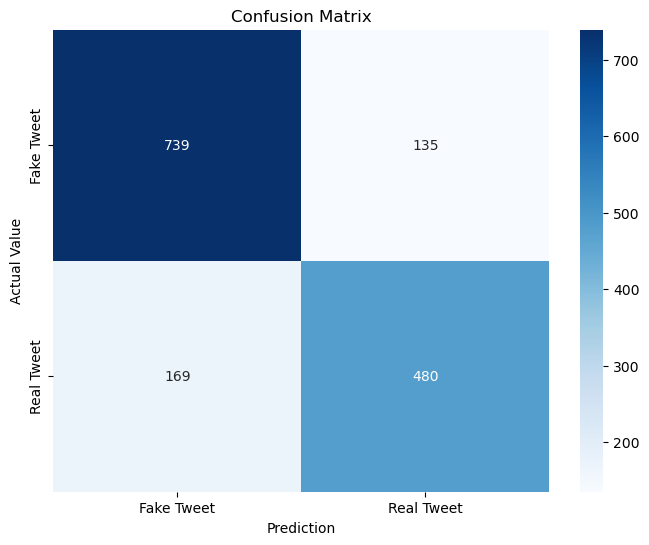

In [101]:
# Create the confusion matrix
pred_labels = [1 if prob >= 0.6 else 0 for prob in all_preds]  # Convert probabilities into class labels
conf_matrix = confusion_matrix(all_labels, pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake Tweet", "Real Tweet"], yticklabels=["Fake Tweet", "Real Tweet"])
plt.xlabel("Prediction")
plt.ylabel("Actual Value")
plt.title("Confusion Matrix")
plt.show()

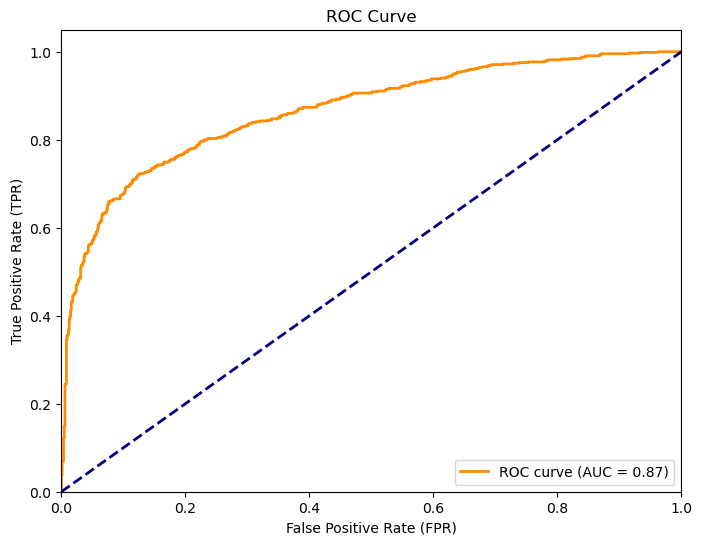

In [102]:
all_labels = torch.tensor(all_labels)
all_preds = torch.tensor(all_preds)

# Calculating the ROC curve and AUC
labels1 = all_labels.numpy()
probs1 = all_preds.numpy()

fpr, tpr, _ = roc_curve(labels1, probs1)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()



In [103]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación
report = classification_report(all_labels, pred_labels, target_names=["Fake Tweet", "Real Tweet"])

# Imprimir el reporte
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

  Fake Tweet       0.81      0.85      0.83       874
  Real Tweet       0.78      0.74      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [104]:
print(roc_auc)

0.8654619146513031
